# China's Ideological LandScape

In [1]:
import matplotlib.colors as mcolors
import pandas as pd
import numpy as np
import pyreadr
from plotnine import *
import missingno as miss
import matplotlib.pyplot as plt
import math
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
dat= pyreadr.read_r('sample10k.RData')
dat= dat['d']

In [3]:
dat= dat.drop(columns= dat.columns[-7:])
dat= dat.reset_index().drop(columns= ["rownames", 'id1', 'id2'], axis=1)
dat.head()

ipwgt  year  month  day        date  newdate  provgb  overseas  gender  \
0  1.000000  2012     10    8  2012-10-08    282.0    11.0       0.0       1   
1  0.333333  2012      9    8  2012-09-08    252.0    15.0       0.0       1   
2  1.000000  2012      4   13  2012-04-13    104.0    33.0       0.0       0   
3  1.000000  2012      3   21  2012-03-21     81.0    44.0       0.0       0   
4  1.000000  2013      5   13  2013-05-13    499.0    33.0       0.0       0   

   birthyear  ...  q40  q47  q42  q43  q49  q45  q48  q41  q44  q50  
0       1983  ...    2    3    4    3    3    1    2    1    1    1  
1       1980  ...    3    3    4    2    3    2    3    1    3    3  
2       1970  ...    3    3    2    3    3    2    1    1    2    3  
3       1978  ...    3    2    2    2    3    2    1    3    3    4  
4       1970  ...    1    1    4    3    3    3    3    1    4    3  

[5 rows x 63 columns]

## Missingness

<AxesSubplot:>

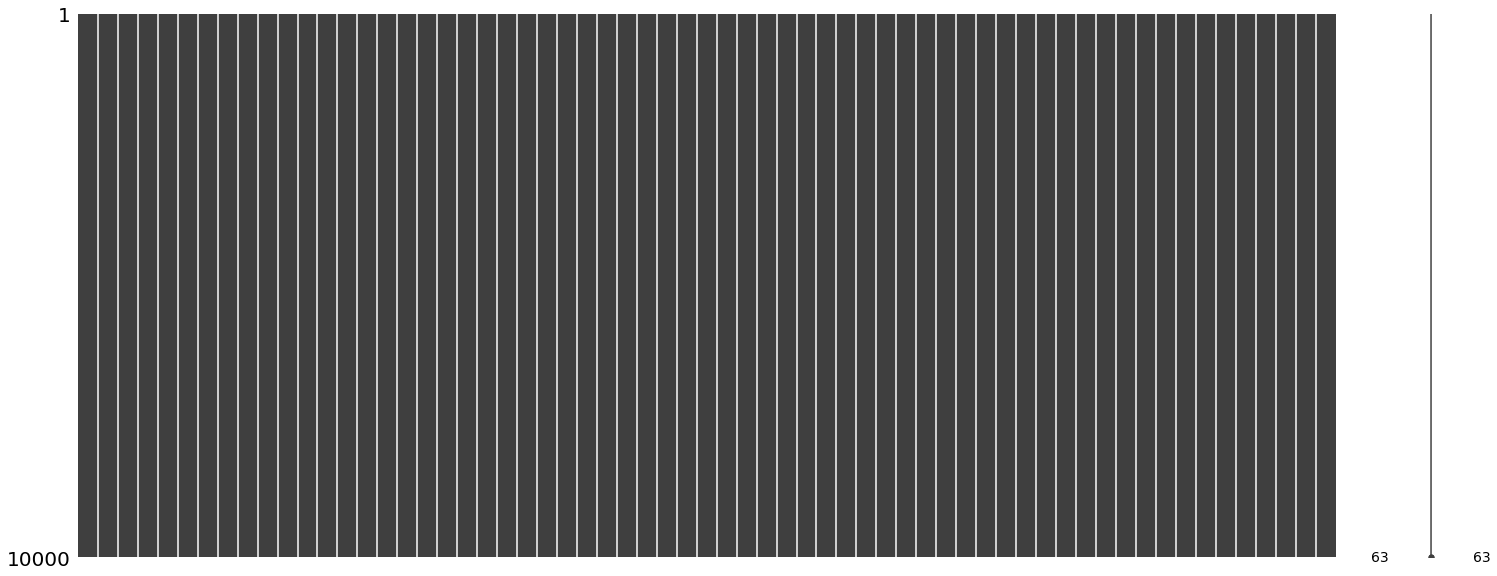

In [4]:
miss.matrix(dat)

## Visualization

In [5]:
viz= dat.copy()

In [6]:
## Make graph more tidy 
education= list()
for i in viz.educ:
    if i==1:
        education.append("Below High School")
    elif i==2:
        education.append("High School")
    elif i==3:
        education.append("College")
    else: 
        education.append("Above College")
        
viz['Education']= education

In [7]:
income= list()
for i in viz.income:
    if i<=2:
        income.append("0-50k")
    elif i>2 and i<=4:
        income.append("50-100k")
    elif i==5:
        income.append("100-150k")
    elif i==6:
        income.append("150-300k")
    else: 
        income.append("Above 300k")

viz['Income']= income

In [8]:
for col in ["Education", "Income", 'q5', 'q3']:
      viz[col] = viz[col].astype('category')

In [9]:
d= viz[["Education", "Income", 'q3','q5']].select_dtypes(include="category").melt()

In [10]:
q3dat = viz[["q3", "Income"]].groupby(
    ["q3", "Income"]).size().unstack("Income").reset_index()
q3dat

Income q3  0-50k  100-150k  150-300k  50-100k  Above 300k
0       1    481        43        89      406          62
1       2   1722       147       258     1362         135
2       3   1407       148       331     1326         135
3       4    763        78       195      754         158

In [11]:
q5dat = viz[["q5", "Income"]].groupby(
    ["q5", "Income"]).size().unstack("Income").reset_index()
q5dat

Income q5  0-50k  100-150k  150-300k  50-100k  Above 300k
0       1    393        35        86      335          71
1       2   1523       148       264     1391         164
2       3   1862       179       398     1638         172
3       4    595        54       125      484          83

### Stacked bar with Dropdown menu

In [12]:
from bokeh.io import output_file, show
from bokeh.models import ColumnDataSource, CustomJS, Select, Div
from bokeh.plotting import figure
from bokeh.palettes import Colorblind
from bokeh.layouts import row, gridplot, column

output_file("stacked.html")

Income = ['0-50k', '50-100k', '100-150k', '150-300k', 'Above 300k']
colors = Colorblind[5]

# Left Barplot
pl = figure(width=498, height=450, title="Q3",
            toolbar_location=None, tools="hover", tooltips="$name: @$name")
pl.vbar_stack(Income, x="q3", width=0.5, source=ColumnDataSource(q3dat), color=colors,
              legend_label=Income)

# Right Barplot
pr = figure(width=498, height=450, title="Q5",
            toolbar_location=None, tools="hover", tooltips="$name: @$name")
pr.vbar_stack(Income, x="q5", width=0.5, source=ColumnDataSource(q5dat), color=colors,
              legend_label=Income)

pr.visible = False
pl.y_range.start = 0
pr.y_range.start = 0
pl.y_range = pr.y_range
pl.xaxis.ticker = [1, 2, 3, 4]
pr.xaxis.ticker = [1, 2, 3, 4]
pl.x_range.range_padding = 0.1
pr.x_range.range_padding = pl.x_range.range_padding
pl.xaxis.major_label_overrides = {
    "1": "Strongly Disagree", "2": "Disagree", "3": "Agree", "4": "Strongly Agree"}
pr.xaxis.major_label_overrides = pl.xaxis.major_label_overrides
pl.xgrid.grid_line_color = None
pl.axis.minor_tick_line_color = None
pl.outline_line_color = None
pr.xgrid.grid_line_color = None
pr.axis.minor_tick_line_color = None
pr.outline_line_color = None
pl.legend.location = "top_left"
pl.legend.orientation = "vertical"
pl.legend.label_text_font_size = "9pt"
pr.legend.label_text_font_size = "9pt"
pl.legend.glyph_width = 9
pr.legend.glyph_width = 9

# Set title
html = """<h3>Q3 and Q5 by Opinion and Income</h3>
<b> Q3 </b> 
<p align= "justify"> When events that have major repercussions for the safety and security of people occur, 
the government should freely disseminate information even if information disclosure increases the risks of unrest. </p>
<b> Q5 </b> 
<p align= "justify"> Indiscriminately imitating western-style freedom of speech \nwill lead to social disorder in China. </p>
"""
sup_title = Div(text=html)


# dropdown widget + Javascript code for interactivity
select = Select(title="Question:", value="Q3", options=["Q3", "Q5"])
select.js_on_change("value", CustomJS(args=dict(q3=pl, q5=pr), code="""

    q3.visible = true
    q5.visible = true

if (this.value === "Q3") {
    q5.visible = false
} else {
    q3.visible = false
}
    
"""))

show(row(column(select, sup_title), pl, pr))

## PCA

In [13]:
colname = []
for i in range(1, 51):
    colname.append(str("q") + str(i))

In [14]:
dat_pca = dat[colname]

In [15]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [16]:
# Scaled to 0-1
scaler = StandardScaler()
dat_std = pd.DataFrame(scaler.fit_transform(dat_pca),
                       columns=dat_pca.columns)

In [17]:
# Use MLE to guess the dimension
pca = PCA(n_components="mle")
mod = pca.fit(dat_std)

In [18]:
mod.explained_variance_ratio_

array([0.19100772, 0.05897758, 0.0417938 , 0.02984833, 0.02825441,
       0.02776973, 0.02518122, 0.02240164, 0.02155833, 0.02015975,
       0.01932619, 0.01903799, 0.01805361, 0.01802879, 0.01774561,
       0.01693721, 0.01652765, 0.01608588, 0.01572784, 0.01555009,
       0.01527395, 0.01513966, 0.01476746, 0.01455036, 0.01428423,
       0.01393457, 0.01387875, 0.01363573, 0.01356855, 0.01320942,
       0.01314983, 0.01279009, 0.01264208, 0.01240271, 0.01212772,
       0.01195986, 0.01159693, 0.0114746 , 0.0113852 , 0.0110411 ,
       0.01085382, 0.01054666, 0.01047034, 0.01032612, 0.01008935,
       0.0099353 , 0.00965189, 0.00909277])

In [19]:
var_ratio = pd.DataFrame(mod.explained_variance_ratio_,
                         index=np.arange(pca.n_components_) + 1,
                         columns=["explain_ratio"])

In [20]:
var_ratio = var_ratio.reset_index().rename(columns={"index":"components"})
var_ratio["cum_var"]= var_ratio["explain_ratio"].cumsum()
var_ratio["eigen"]= mod.explained_variance_

In [21]:
var_ratio.head(10)

components  explain_ratio   cum_var     eigen
0           1       0.191008  0.191008  9.551341
1           2       0.058978  0.249985  2.949174
2           3       0.041794  0.291779  2.089899
3           4       0.029848  0.321627  1.492566
4           5       0.028254  0.349882  1.412862
5           6       0.027770  0.377652  1.388625
6           7       0.025181  0.402833  1.259187
7           8       0.022402  0.425234  1.120194
8           9       0.021558  0.446793  1.078024
9          10       0.020160  0.466953  1.008088

In [22]:
var_ratio["ratio_increase"] = var_ratio["explain_ratio"] / \
    (var_ratio["cum_var"] - var_ratio["explain_ratio"])
var_ratio["cum_var"] = var_ratio["cum_var"]*100

### Screeplot

In [22]:
from bokeh.models import Span, LinearAxis, Range1d, Label

output_file("screeplot.html")
source = ColumnDataSource(var_ratio)

# Scree plot
pl = figure(width=808, height=438, title="Scree plot and Cumulative Variance Explaied plot",
            toolbar_location=None, tools="hover",
            tooltips=[("# of Components", "@components"), ("Eigenvale", "@eigen"), ("Cumulative Variance Explaied", "@cum_var")])

pl.vbar(x="components", top="eigen", source=source, width=0.8, color=colors[0])
pl.y_range = Range1d(0, 10)

# Add a horizontal line
hline = Span(location=1, dimension='width', line_color=colors[1],
             line_dash='dashed', line_width=2)
pl.renderers.extend([hline])


# Line plot for cumulative variance explained
pl.extra_y_ranges = {"Variance": Range1d(start=0, end=100)}
pl.add_layout(LinearAxis(y_range_name="Variance"), 'right')
pl.line(x="components", y="cum_var", source=source,
        width=2, y_range_name="Variance", color=colors[3])

# Add text `Kaiser Rule`
citation = Label(x=9, y=1.5, text_color=colors[1],
                 text='Kaiser Rule', render_mode='css',
                 background_fill_color='white', background_fill_alpha=1.0)

pl.add_layout(citation)
show(pl)

### PCA Matrix

In [23]:
import pandas as pd
import plotly.express as px

n_components = 8

pca_mod = PCA(n_components=n_components)
components = pca_mod.fit_transform(dat_std)

total_var = pca_mod.explained_variance_ratio_.sum() * 100

labels = {str(i): f"PC {i+1}" for i in range(n_components)}
labels['color'] = 'Income'

fig = px.scatter_matrix(components,
    width=800,
    height=800,
    color= dat.income,
    dimensions=range(n_components),
    labels=labels,
    title=f'Total Explained Variance: {total_var:.2f}%',
)


fig.update_traces(diagonal_visible=False)
fig.show()

## Clustering

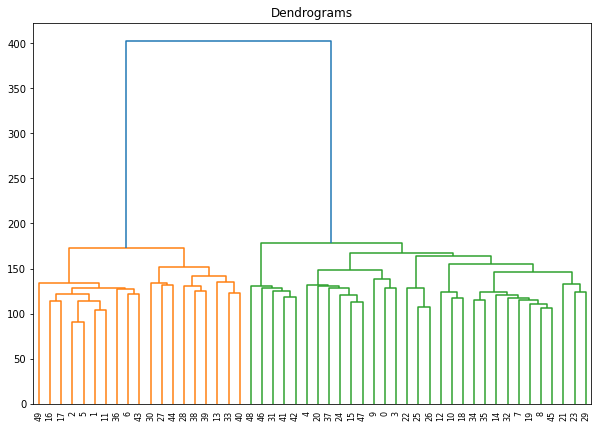

In [24]:
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(dat_std.T, method='ward'))

## Preprocessing

### `educ`

In [25]:
# Create education dummies
edu_dummies = pd.get_dummies(dat.educ)
edu_dummies.columns = ["bhs", "hs", "college", "above_college"]

In [26]:
dat = pd.concat([dat.drop(['educ'], axis=1), edu_dummies], axis=1)

### `Income`

In [27]:
# create income dummies
i0_50k = [1 if i <= 2 else 0 for i in dat.income]
i50_100k = [1 if i > 2 and i <= 4 else 0 for i in dat.income]
i100_150k = [1 if i == 5 else 0 for i in dat.income]
i150_300k = [1 if i == 6 else 0 for i in dat.income]
ia300k = [1 if i == 7 else 0 for i in dat.income]

In [28]:
inc = pd.DataFrame()
for i in [i0_50k, i50_100k, i100_150k, i150_300k, ia300k]:
    output = pd.DataFrame(i)
    inc = pd.concat([inc, output], axis=1)

inc.columns = ['i0_50k', 'i50_100k', 'i100_150k', 'i150_300k', 'ia300k']

In [29]:
inc.sum()/len(inc)

i0_50k       0.4373
i50_100k     0.3848
i100_150k    0.0416
i150_300k    0.0873
ia300k       0.0490
dtype: float64

In [30]:
dat = pd.concat([dat.drop(columns=['income'], axis=1), inc], axis=1)

###  `provgb`

In [31]:
# create region dummies
north = [1 if i in range(10, 20) else 0 for i in dat.provgb]
northeast = [1 if i in range(20, 30) else 0 for i in dat.provgb]
east = [1 if i in range(30, 40) else 0 for i in dat.provgb]
southcentral = [1 if i in range(40, 50) else 0 for i in dat.provgb]
southwest = [1 if i in range(50, 60) else 0 for i in dat.provgb]
northwest = [1 if i in range(60, 70) else 0 for i in dat.provgb]

In [32]:
region = pd.DataFrame()
for i in [north, northeast, east, southcentral, southwest, northwest]:
    output = pd.DataFrame(i)
    region = pd.concat([region, output], axis=1)

# Adjust the column name
region.columns = ['north', 'northeast', 'east',
                  'southcentral', 'southwest', 'northwest']

In [33]:
# Get the ratio of each region
region.sum()/len(region)

north           0.1387
northeast       0.1130
east            0.3153
southcentral    0.2935
southwest       0.0889
northwest       0.0506
dtype: float64

In [34]:
dat = pd.concat([dat.drop(columns=['provgb'], axis=1), region], axis=1)

In [35]:
dat.head()

ipwgt  year  month  day        date  newdate  overseas  gender  \
0  1.000000  2012     10    8  2012-10-08    282.0       0.0       1   
1  0.333333  2012      9    8  2012-09-08    252.0       0.0       1   
2  1.000000  2012      4   13  2012-04-13    104.0       0.0       0   
3  1.000000  2012      3   21  2012-03-21     81.0       0.0       0   
4  1.000000  2013      5   13  2013-05-13    499.0       0.0       0   

   birthyear  age  ...  i50_100k  i100_150k  i150_300k  ia300k  north  \
0       1983   29  ...         1          0          0       0      1   
1       1980   32  ...         1          0          0       0      1   
2       1970   42  ...         1          0          0       0      0   
3       1978   34  ...         0          0          1       0      0   
4       1970   43  ...         1          0          0       0      0   

   northeast  east  southcentral  southwest  northwest  
0          0     0             0          0          0  
1          0     0             0          0          0  
2          0     1             0          0          0  
3          0     0             1          0          0  
4          0     1             0          0          0  

[5 rows x 75 columns]

### Binary scale

In [36]:
dat = dat.drop(columns=dat.columns[: 7], axis=1)

In [37]:
dat_bi = dat.copy()

# Transfer categorical variables to binary scale
for i in range(50):
    colname = str('q') + str(i+1)
    dat_bi[colname] = 1*(dat_bi[colname] > 2.5)

In [38]:
# Create dummies for people's combination preferences for Q3 and Q5
dat_bi['i0'] = np.where((dat_bi['q3'] + dat_bi['q5'] == 0), 1, 0)
dat_bi['i01'] = np.where(dat_bi['q3'] < dat_bi['q5'], 1, 0)
dat_bi['i10'] = np.where(dat_bi['q3'] > dat_bi['q5'], 1, 0)
dat_bi['i2'] = np.where(dat_bi['q3'] + dat_bi['q5'] == 2, 1, 0)

In [39]:
dat_bi['overlap'] = dat_bi['college'] + \
    dat_bi['above_college'] + dat_bi['i150_300k']
print(dat_bi['college'].value_counts(), dat_bi['above_college'].value_counts())

1    6721
0    3279
Name: college, dtype: int64 0    8380
1    1620
Name: above_college, dtype: int64


In [40]:
dat_bi['overlap'].value_counts()[2]/dat_bi['i150_300k'].value_counts()[1]

0.9392898052691867

In [41]:
dat_bi = dat_bi.drop(columns=["overlap"], axis=1)

### Synthetic Index

In [42]:
# Political Institutions (PI) includes Q1,2,3,4,5,10,12,13,14,17
# Pro-democracy direction is 1, pro-authoritarianism is -1
# Deduct 2.5 for every question to make sure the midpoint is 0

pi = dat[['q2', 'q4', 'q1', 'q10', 'q12', 'q13', 'q14', 'q17']] - 2.5
pi_index = pi['q2'] - pi['q4'] + pi['q1'] - pi['q10'] + \
    pi['q12'] - pi['q13'] + pi['q14'] + pi['q17']

In [43]:
## Individual Freedom (fr) includes Q6,7,8,24,44,45
## Pro-freedom (+1), anti-freedom(-1)
fr= dat[['q6','q7','q8','q24','q44','q45']]-2.5
fr_index= fr['q6']+ fr['q7']- fr['q8']+ fr['q24']- fr['q44']+ fr['q45']

In [44]:
## Free Market (fm) includes Q21,25,27,29,30,37,40
fm= dat[['q21','q25','q27','q29','q30','q37','q40']]-2.5
fm_index= -0.5*fm['q21']- fm['q25']- fm['q27']+ fm['q29']- fm['q30']+ fm['q37']+ 0.5*fm['q40']

In [45]:
## Labor vs Capital (soc) includes Q22,31,33,34,36,38
## Pro-Socialism (+1), anti-Socialism(-1)
soc= dat[['q22','q31','q32','q33','q34','q36','q38']]- 2.5
soc_index= (soc['q22']- soc['q31']+ soc['q32']+ soc['q33']- soc['q34']- soc['q36']+ soc['q38'])

In [46]:
## Globalization (GLO) includes Q23,26,28,35,39
## Pro-globalization (+1), anti-globalization (-1)
glo= dat[['q11','q23','q26','q28','q35','q39']]- 2.5
glo_index= glo['q11']- glo['q23']- glo['q26']+ glo['q39']- glo['q28']- glo['q35']

In [47]:
## Traditionalism (TR) includes Q41,42,43,46,47,48,49,50
## Pro-tradition (+1), pro-modernization(-1)
tr= dat[['q41','q42','q43','q46','q47','q48','q49','q50']]- 2.5
tr_index= -(tr['q41']-tr['q42']- tr['q43']- tr['q46']- tr['q47']- tr['q48']- tr['q49']+ tr['q50'])

In [48]:
## Nationalism (NAT) includes Q9,11,15,16,18,19,20
## Pro-nationalism(+1), anti-nationalism(-1)
nat= dat[['q9','q15','q16','q18','q19','q20']]- 2.5
nat_index= nat['q9']+ nat['q15']+ nat['q16']- nat['q18']+ nat['q19']+ nat['q20']

In [49]:
df_index= pd.DataFrame(dict(Democracy= pi_index, Freedom= fr_index,
                            Market= fm_index, Socialism= soc_index,
                            Globalization= glo_index, Traditionalism= tr_index, Nationalism= nat_index))
corr = df_index.corr()
corr

Democracy   Freedom    Market  Socialism  Globalization  \
Democracy        1.000000  0.311000  0.506926  -0.323710       0.088113   
Freedom          0.311000  1.000000  0.242034  -0.112926       0.023090   
Market           0.506926  0.242034  1.000000  -0.383166       0.298983   
Socialism       -0.323710 -0.112926 -0.383166   1.000000      -0.180820   
Globalization    0.088113  0.023090  0.298983  -0.180820       1.000000   
Traditionalism  -0.496901 -0.167249 -0.549212   0.430743      -0.191904   
Nationalism     -0.640576 -0.362105 -0.607873   0.375132      -0.183326   

                Traditionalism  Nationalism  
Democracy            -0.496901    -0.640576  
Freedom              -0.167249    -0.362105  
Market               -0.549212    -0.607873  
Socialism             0.430743     0.375132  
Globalization        -0.191904    -0.183326  
Traditionalism        1.000000     0.584949  
Nationalism           0.584949     1.000000

In [50]:
df_index.mean()

Democracy         0.12780
Freedom          -0.52510
Market           -0.50635
Socialism         1.55590
Globalization    -1.05710
Traditionalism    0.75540
Nationalism       1.00690
dtype: float64

### Distribution

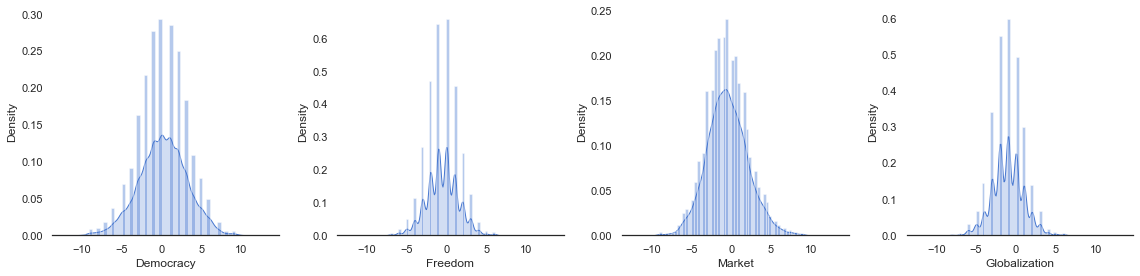

In [51]:
sns.set(style="white", palette="muted", color_codes=True)
f, ax = plt.subplots(1, 4, figsize=(16, 4), sharex=True)
sns.despine(left=True)
# Plot a simple histogram with binsize determined automatically
sns.distplot(df_index["Democracy"], kde=True, color="b",kde_kws={"shade": True}, ax=ax[0])
sns.distplot(df_index["Freedom"], kde=True, color="b",kde_kws={"shade": True},ax=ax[1])
sns.distplot(df_index["Market"], kde=True, color="b", kde_kws={"shade": True}, ax=ax[2])
sns.distplot(df_index["Globalization"], kde=True, color="b", kde_kws={"shade": True}, ax=ax[3])
plt.tight_layout()

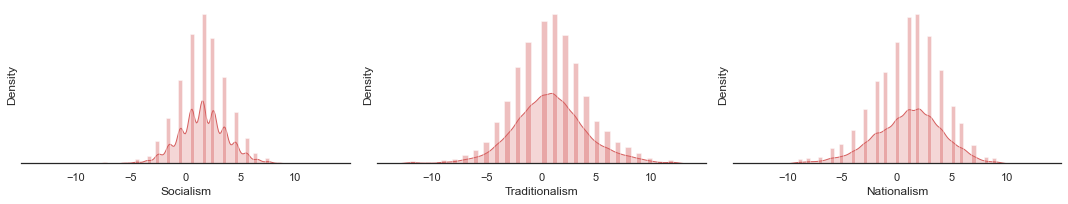

In [52]:
sns.set(style="white", palette="muted", color_codes=True)
f, ax = plt.subplots(1, 3, figsize=(15, 3), sharex=True)
sns.despine(left=True)

# Plot a simple histogram with binsize determined automatically
sns.distplot(df_index["Socialism"], kde=True, color="r", kde_kws={"shade": True}, ax=ax[0])
sns.distplot(df_index["Traditionalism"], kde=True, color="r", kde_kws={"shade": True}, ax=ax[1])
sns.distplot(df_index["Nationalism"], kde=True, color="r", kde_kws={"shade": True}, ax=ax[2])

plt.setp(ax, yticks= [])
plt.tight_layout()
# plt.savefig('visualizations/index_2.png', dpi=400)

### Distplot

In [53]:
import plotly.figure_factory as ff
from plotly.graph_objs import *

# Labels for naming
group_labels = ["Democracy", "Freedom", "Market",
                "Globalization", "Socialism", "Traditionalism", "Nationalism"]

hist_data = []
for i in group_labels:
    hist_data.append(df_index[i].to_list())

# Keep consistent color
color_px = Colorblind[7]

## Distribution with kde
fig = ff.create_distplot(
    hist_data, group_labels=group_labels, show_hist=False, curve_type='kde', colors=color_px)

# Update layout
fig.update_layout({"title": "Distribution of Each Index",
                   "width": 800,
                   "height": 430,
                   'paper_bgcolor': 'rgba(0,0,0,0)',
                   'plot_bgcolor': 'rgba(0,0,0,0)'})

fig.write_html("distplot.html")

### Correlation matrix

<AxesSubplot:>

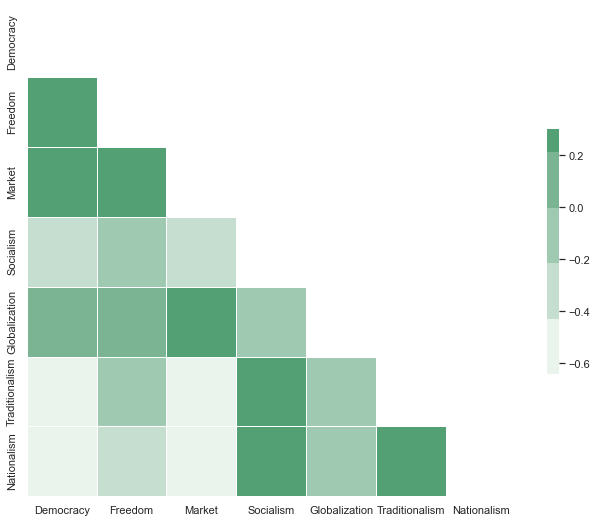

In [54]:
# Generate a mask for the upper triangle
mask= np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f,ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap= sns.light_palette("seagreen")

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

#f.savefig("visualizations/corrmatrix.png", dpi=400)

In [55]:
import plotly.graph_objects as go

# Only Include the lower triangular matrix
mask = np.triu(np.ones_like(corr, dtype=np.bool))
corr = corr.mask(mask)

# Initiate the figure
fig = go.Figure()

# Add heatmap
fig.add_trace(go.Heatmap(
    z=corr.to_numpy().round(2),
    x=list(corr.index.values),
    y=list(corr.columns.values),
    xgap=1, ygap=1,
    zmin=-1, zmax=1,
    colorscale="mint",  ## Select mint as color
    colorbar_thickness=10,
    colorbar_ticklen=3,
    hoverongaps=False, ## Disable hover tools on empty
    hovertemplate='Cor(%{x},%{y}) = %{z} <extra></extra>',))

# Update the layout
fig.update_layout(title_text='<b>Correlation Matrix<b>',
                  titlefont={'size': 18},
                  width=800, height=450,
                  xaxis_showgrid=False,
                  xaxis={'side': 'bottom'},
                  yaxis_showgrid=False,
                  template='plotly_white',
                  yaxis_autorange='reversed')


# Hide the ModeBar
config = {'displayModeBar': False}
fig.show(config=config)
fig.write_html("corrmatrix.html", config=config)

In [56]:
def corr(x, y, **kwargs):
    
    # Calculate the value
    coef = np.corrcoef(x, y)[0][1]
    # Make the label
    label = r'$\rho$ = ' + str(round(coef, 2))
    
    # Add the label to the plot
    ax = plt.gca()
    ax.annotate(label, xy =(0.2, 0.90), size= 15, xycoords = ax.transAxes)

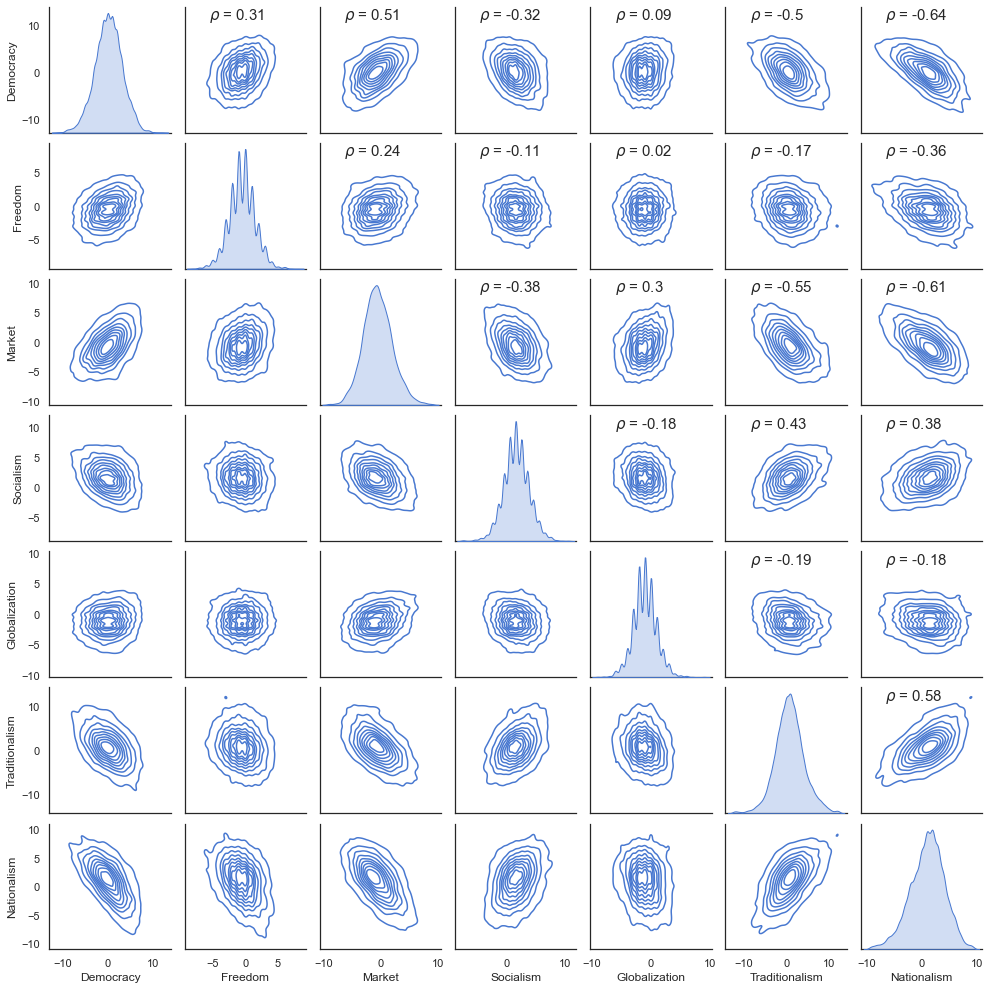

In [57]:
grid= sns.pairplot(df_index,
             kind= 'kde', height=2)
grid= grid.map_upper(corr)
# grid.savefig("visualizations/pairplot.png")

## Statistical Methods

In [58]:
from sklearn import preprocessing as pp 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from imblearn.over_sampling import SMOTE 

from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
from scipy.stats import uniform
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.tree import DecisionTreeRegressor as DTreg
from sklearn import tree 
from sklearn.ensemble import RandomForestClassifier as RF

import sklearn.metrics as m

from sklearn.inspection import permutation_importance
#from pdpbox import pdp

In [59]:
# Create outcome variables
df_index['q5'] = 1 * (dat['q5'] > 2.5)
df_index['q3'] = 1 * (dat['q3'] > 2.5)

for i in dat.columns[53:]:
    df_index[i] = dat[i]

df_index['age'] = dat['age']
df_index['gender'] = dat['gender']

In [60]:
# Create outcome variables for combination preferences 
df_index['qs2']= np.where(df_index['q3']+ df_index['q5']==2, 1, 0)
df_index['qs10']= np.where((df_index['q3']> df_index['q5']), 1, 0)
df_index['qs01']= np.where((df_index['q3']< df_index['q5']), 1, 0)
df_index['qs0']= np.where(df_index['q3']+ df_index['q5']==0, 1, 0)

for i in ['qs0','qs10', 'qs01','qs2']:
    print(df_index[i].value_counts())

0    8344
1    1656
Name: qs0, dtype: int64
0    7246
1    2754
Name: qs10, dtype: int64
0    6951
1    3049
Name: qs01, dtype: int64
0    7459
1    2541
Name: qs2, dtype: int64


In [61]:
df_index.to_csv("cls_index.csv")

In [62]:
df_index.head(5)

Democracy  Freedom  Market  Socialism  Globalization  Traditionalism  \
0       -3.0     -4.0    -4.0        3.5           -1.0             7.0   
1        4.0     -5.0     0.0        1.5            1.0             4.0   
2        4.0      2.0     0.0        6.5           -4.0             1.0   
3        2.0      1.0     0.5       -1.5           -3.0            -6.0   
4       -2.0     -1.0     0.0        4.5           -6.0             3.0   

   Nationalism  q5  q3  bhs  ...  east  southcentral  southwest  northwest  \
0          6.0   1   0    0  ...     0             0          0          0   
1          3.0   1   0    0  ...     0             0          0          0   
2         -2.0   0   1    0  ...     1             0          0          0   
3         -6.0   1   1    0  ...     0             1          0          0   
4          5.0   0   1    0  ...     1             0          0          0   

   age  gender  qs2  qs10  qs01  qs0  
0   29       1    0     0     1    0  
1   32       1    0     0     1    0  
2   42       0    0     1     0    0  
3   34       0    1     0     0    0  
4   43       0    0     1     0    0  

[5 rows x 30 columns]

### Index `q5` 

In [63]:
yi5 = df_index['q5']
Xi5 = df_index.drop(columns=['q5', 'q3', 'qs2','qs10','qs01','qs0'], axis=1)
train_Xi5, test_Xi5, train_yi5, test_yi5= train_test_split(Xi5,yi5,test_size = .25,random_state=123)

In [64]:
# Set up LR
LR = LogisticRegression(solver='saga', tol=1e-2, max_iter=500,
                        random_state=123)

distributions = dict(C=uniform(0, 10), penalty=['l1', 'l2', 'none'])

In [65]:
rad_search_iq5= RandomizedSearchCV(LR, distributions, random_state=123)

rad_search_iq5.fit(train_Xi5,train_yi5)

RandomizedSearchCV(estimator=LogisticRegression(max_iter=500, random_state=123,
                                                solver='saga', tol=0.01),
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f84064f6cd0>,
                                        'penalty': ['l1', 'l2', 'none']},
                   random_state=123)

In [67]:
print(rad_search_iq5.best_score_, rad_search_iq5.best_estimator_)

0.6102666666666667 LogisticRegression(C=0.5967789660956835, max_iter=500, penalty='l1',
                   random_state=123, solver='saga', tol=0.01)


In [68]:
glmiq5= rad_search_iq5.best_estimator_
glmiq5_pred_y= glmiq5.predict(test_Xi5)
m.accuracy_score(test_yi5, glmiq5_pred_y)

0.6104

In [69]:
glm_iq5= pd.DataFrame(dict(variable= train_Xi5.columns))
glm_iq5['coef']= rad_search_iq5.best_estimator_.coef_.tolist()[0]
glm_iq5.head(5)

variable      coef
0      Democracy -0.049490
1        Freedom -0.052308
2         Market -0.057217
3      Socialism  0.009120
4  Globalization  0.038824

#### Statistical Model

In [70]:
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import logit

In [71]:
a= train_Xi5.copy()
a['q5']= train_yi5

In [72]:
ff_iq5= "q5~Democracy+ Freedom+ Market+ Socialism+ Globalization+ Traditionalism+ Nationalism+ hs+ college+ above_college+ i50_100k+ i100_150k+ i150_300k+ ia300k+ north+ northeast+ east+ southcentral+ southwest+ age+ gender"

In [73]:
glm_mod_iq5 = logit(ff_iq5, data= a).fit_regularized(method= "l1", alpha= 1/(0.5967789660956835))

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.6557886296149207
            Iterations: 126
            Function evaluations: 130
            Gradient evaluations: 126


In [74]:
## Create a 95% CIs
glm_iq5= glm_mod_iq5.conf_int().iloc[1:]
glm_iq5['coef']= glm_mod_iq5.params
glm_iq5.columns= ['low', 'high', 'coef']
glm_iq5= glm_iq5.reset_index().rename(columns={"index": "variable"})
glm_iq5['sd']= abs((glm_iq5['high']- glm_iq5['low'])/2)
glm_iq5.head(5)

variable       low      high      coef        sd
0      Democracy -0.071910 -0.029408 -0.050659  0.021251
1        Freedom -0.076567 -0.023636 -0.050101  0.026466
2         Market -0.084849 -0.033484 -0.059166  0.025683
3      Socialism -0.015564  0.033684  0.009060  0.024624
4  Globalization  0.015301  0.065874  0.040588  0.025287

In [75]:
labels= ['Democracy','Freedom','Market','Socialism','Globalization','Traditionalism', 'Nationalism','High School',
 'College','Above College','50-100k','100-150k','150-300k','Above 300k',
 'North','Northeast','East','Southcentral','Southwest','Age','Gender']
glm_iq5["labels"] = labels

In [76]:
glm_iq5.columns= ["labels", "lower bound", "upper bound", "coefficient", "sd", "variable"]

### `q3`~Index

In [77]:
# Train-test split
yi3 = df_index['q3']
Xi3 = df_index.drop(columns=['q5', 'q3', 'qs2','qs10','qs01','qs0'], axis=1)
train_Xi3, test_Xi3, train_yi3, test_yi3= train_test_split(Xi3,yi3,test_size = .25,random_state=123)

In [78]:
# Randomly search the best penalty
rad_search_iq3 = RandomizedSearchCV(LR, distributions, random_state=123)

rad_search_iq3.fit(train_Xi3,train_yi3)

RandomizedSearchCV(estimator=LogisticRegression(max_iter=500, random_state=123,
                                                solver='saga', tol=0.01),
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f84064f6cd0>,
                                        'penalty': ['l1', 'l2', 'none']},
                   random_state=123)

In [79]:
print(rad_search_iq3.best_score_, rad_search_iq3.best_estimator_)

0.7194666666666667 LogisticRegression(C=0.5967789660956835, max_iter=500, penalty='l1',
                   random_state=123, solver='saga', tol=0.01)


In [80]:
glmiq3= rad_search_iq3.best_estimator_
glmiq3_pred_y= glmiq3.predict(test_Xi3)
m.accuracy_score(test_yi3, glmiq3_pred_y)

0.7208

In [82]:
b= train_Xi3.copy()
b['q3']= train_yi3

In [83]:
ff_iq3= "q3~Democracy+ Freedom+ Market+ Socialism+ Globalization+ Traditionalism+ Nationalism+ hs+ college+ above_college+ i50_100k+ i100_150k+ i150_300k+ ia300k+ north+ northeast+ east+ southcentral+ southwest+ age+ gender"

In [84]:
glm_mod_iq3 = logit(ff_iq3,b).fit_regularized(method= "l1", alpha= 1/(0.5967789660956835))

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5376051980190013
            Iterations: 132
            Function evaluations: 136
            Gradient evaluations: 132


In [86]:
## Create a 95% CIs
glm_iq3= glm_mod_iq3.conf_int().iloc[1:]
glm_iq3['coefficient']= glm_mod_iq3.params
glm_iq3.columns= ['low', 'high', 'coefficient']
glm_iq3= glm_iq3.reset_index().rename(columns={"index": "variable"})
glm_iq3['sd']= abs((glm_iq3['high']- glm_iq3['low'])/2)
glm_iq3["label"] = labels
glm_iq3.columns= ["labels", "lower bound", "upper bound", "coefficient", "sd", "variable"]

In [87]:
import altair as alt

# coefficient dot for Q5
q5 = alt.Chart(glm_iq5, title="Not Support Imitating Western-style Freedom").mark_point(filled=True, color='black').encode(
    x=alt.X("coefficient"),
    y=alt.Y('variable'),
).properties(
    width=270,
    height=360
)

# Add error bar for Q5
error_bars_q5 = q5.mark_errorbar().encode(
    x=alt.X('lower bound',  axis=alt.Axis(title='Coefficient')),
    x2='upper bound',

)

# coefficient dot for Q3
q3 = alt.Chart(glm_iq3, title="Support Information Transparency under the Crisis").mark_point(filled=True, color='black').encode(
    x=alt.X("coefficient"),
    y=alt.Y('variable'),
).properties(
    width=270,
    height=360
)

# Add error bar for Q3
error_bars_q3 = q3.mark_errorbar().encode(
    x=alt.X('lower bound',  axis=alt.Axis(title='Coefficient')),
    x2='upper bound',

)

# Add line
line = alt.Chart(pd.DataFrame({'x': [0.0]})).mark_rule(
    color="red").encode(x='x')

# Combine two plots together and save
(q3 + error_bars_q3 + line | q5 + error_bars_q5 + line).save("stats_result_1.html")